In [1]:
import numpy as np

from copy import copy

from pycbc.types import TimeSeries, load_frequencyseries
from pycbc.psd import interpolate

from scipy.signal import windows
from scipy.interpolate import interp1d

import ldc.io.hdf5 as hdfio

from matplotlib import pyplot as plt
plt.style.use('../paper.mplstyle')

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
# This cell contains the information about inputs

input_data = '../datasets/LDC2_sangria_hm_training.hdf'
output_format = '{channel}_sangria_hm_PSD.txt'
segment_duration = 1576800

In [3]:
# Load in the sangria dataset

tdi_ts, tdi_descr = hdfio.load_array(input_data, name="obs/tdi")
X = tdi_ts['X']
Y = tdi_ts['Y']
Z = tdi_ts['Z']

In [4]:
# Convert to AET timeseries
A = (Z - X)/np.sqrt(2)
E = (X - 2*Y + Z)/np.sqrt(6)
T = (X + Y + Z)/np.sqrt(3)

A_ts = TimeSeries(A, delta_t=5.)
E_ts = TimeSeries(E, delta_t=5.)
T_ts = TimeSeries(T, delta_t=5.)

In [5]:
# Calculate the PSDs

A_psd = A_ts.psd(segment_duration)
E_psd = E_ts.psd(segment_duration)
T_psd = T_ts.psd(segment_duration)

A_psd = interpolate(A_psd, A_ts.delta_f)
E_psd = interpolate(E_psd, E_ts.delta_f)
T_psd = interpolate(T_psd, T_ts.delta_f)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
# Save to files for use in later analysis

# A_psd.save(output_format.format(channel='A'))
# E_psd.save(output_format.format(channel='E'))
# T_psd.save(output_format.format(channel='T'))

In [7]:
# We also want to plot the models that we used in the premerger paper
ae_model = load_frequencyseries('model_AE_TDI1_optimistic.txt')
ae_model = ae_model[:1000001]
ae_model = ae_model.astype(np.complex128)
t_model = load_frequencyseries('model_T_TDI1_optimistic.txt')


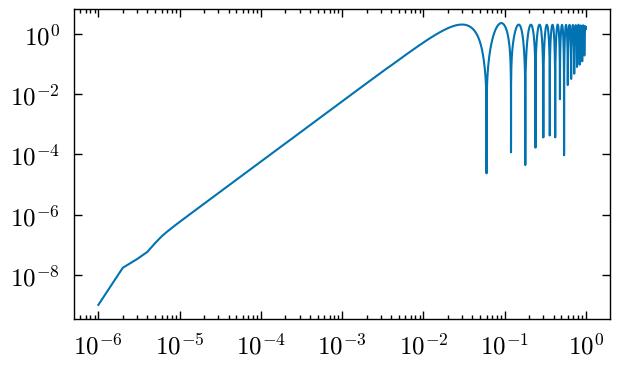

In [8]:
# Load the AE response function from the file used in the premerger paper
f = ae_model.sample_frequencies[:-100]
ae_raw = np.genfromtxt('AE_response_function.txt')
plt.loglog(f, ae_raw)

In [9]:
# From Babak, Petiteau and Hewitson, 2021
# Constants
A = 1.14e-44
alpha = 1.8
f2 = 0.31
a1 = -0.25
b1 = -2.7
ak = -0.27
bk = -2.47

def f1fk(tobs):
    f1 = (a1 * np.log10(tobs) + b1) ** 10
    fk = (ak * np.log10(tobs) + bk) ** 10
    return f1, fk

def sgal(fm, tobs):
    f1, fk = f1fk(tobs)
    return 0.5 * A * fm ** (-7/3) * np.exp(-1 * (fm / f1) * alpha) * (1 + np.tanh(- (fm - fk) / (f2)))

def wd_background(tobs):
    fm = f * 1000
    wd_cs = sgal(fm, tobs)
    return wd_cs * ae_raw ** 2

tb_labels = ['6 months', '1 year', '2 years', '4 years']
wd_backgrounds_bph = {
    tbl: wd_background(tby)
    for tbl, tby in zip(
        tb_labels,
        [0.5, 1, 2, 4]
    )
}

print("wd_backgrounds_bph", wd_backgrounds_bph)

tb_linestyles = {
    tbl: ls for tbl, ls in zip(tb_labels, ['-','--', '-.', ':'])
}
# for lbl, wdb in wd_backgrounds.items():
#     plt.semilogy(f, wdb, label=lbl, linestyle=tb_linestyles[lbl], c='k')


/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other


wd_backgrounds_bph {'6 months': <pycbc.types.array.Array object at 0x7fd8a2362590>, '1 year': <pycbc.types.array.Array object at 0x7fd8a2360580>, '2 years': <pycbc.types.array.Array object at 0x7fd8a23625c0>, '4 years': <pycbc.types.array.Array object at 0x7fd8a2360490>}


In [10]:
# From Robson, Cornish and Liu, 2019
A = 9e-45

# Choose one of these:
fit_params_6mo = (0.133, 243, 482, 917, 0.00258)
fit_params_1yr = (0.171, 292, 1020, 1680, 0.00215)
fit_params_2yr = (0.165, 299, 611, 1340, 0.00173)
fit_params_4yr = (0.138, -221, 521, 1680, 0.00113)

def wd_background(fit_params):
    alpha, beta, kappa, gamma, fk = fit_params

    # This is in characteristic strain
    wd_cs = A * f ** (-7/3) * np.exp(-f * alpha + beta * f * np.sin(kappa * f)) * (1 + np.tanh(gamma * (fk - f)))

    return wd_cs * ae_raw ** 2


tb_labels = ['6 months', '1 year', '2 years', '4 years']
wd_backgrounds_rcl = {
    tb: wd_background(fp)
    for tb, fp in zip(
        tb_labels,
        [fit_params_6mo, fit_params_1yr, fit_params_2yr, fit_params_4yr]
    )
}

print("wd_backgrounds_rcl", wd_backgrounds_rcl)

# tb_linestyles = {
#     tbl: ls for tbl, ls in zip(tb_labels, ['-','--', '-.', ':'])
# }

wd_backgrounds_rcl {'6 months': <pycbc.types.array.Array object at 0x7fd8ac275e10>, '1 year': <pycbc.types.array.Array object at 0x7fd8a230c520>, '2 years': <pycbc.types.array.Array object at 0x7fd8a23612d0>, '4 years': <pycbc.types.array.Array object at 0x7fd8a2362f20>}


/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


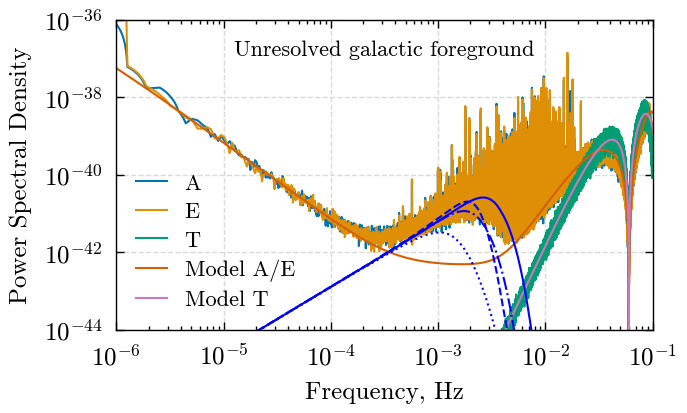

In [11]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd, c=cycle[0], label='A')
ax.loglog(E_psd.sample_frequencies, E_psd, c=cycle[1], label='E')
ax.loglog(T_psd.sample_frequencies, T_psd, c=cycle[2], label='T')
ax.loglog(ae_model.sample_frequencies, ae_model, c=cycle[3], label='Model A/E')
ax.loglog(t_model.sample_frequencies, t_model, c=cycle[4], label='Model T')

ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
leg1 = ax.legend(loc='lower left')
line2 = []
labels2 = []
# for tb, wdb in wd_backgrounds_bph.items():
#     line2.append(ax.loglog(f, wdb, c='k', linestyle=tb_linestyles[tb])[0])
#     labels2.append(tb)
for tb, wdb in wd_backgrounds_rcl.items():
    ax.loglog(f, wdb, c='b', linestyle=tb_linestyles[tb])[0]
ax.legend(line2, labels2, loc="upper center", title="Unresolved galactic foreground")
ax.add_artist(leg1)
ax.set_ylim([1e-44, 1e-36])
ax.set_xlim([1e-6, 1e-1])
ax.grid(zorder=-100)

Now lets remove the dip at 0.06 Hz

First lets find the peaks either side, so that we can 'bridge the gap' 

/home/gareth/miniconda3/envs/env_lisa_premerger/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:266: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


0.03504303329088329 0.0972670924037424


(0.01, 0.12)

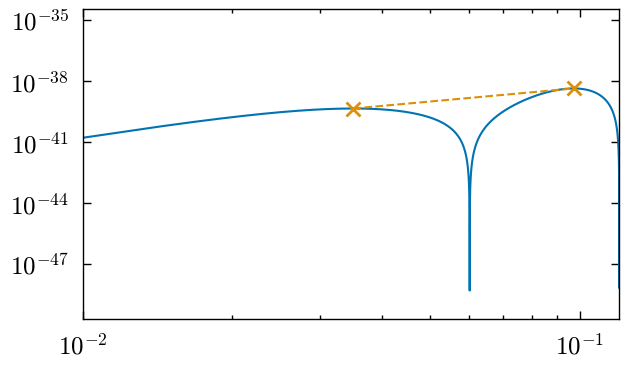

In [12]:
from scipy.signal import find_peaks

pks = find_peaks(
    np.where(
        np.logical_and(
            ae_model.sample_frequencies > 2e-3,
            ae_model.sample_frequencies < 0.12
        ),
        ae_model,
        0
    )
)[0]

section_lower, section_upper = ae_model.sample_frequencies[pks]
print(section_lower, section_upper)

plt.loglog(ae_model.sample_frequencies, ae_model)
plt.plot(ae_model.sample_frequencies[pks], ae_model[pks], linestyle='--', marker='x')
plt.xlim(left=1e-2, right=0.12)

So the peaks are at [0.03504303 0.09726709]

Lets use them to define a section which will be smoothed out, we will apply a window to the PSD, and the opposite window to this straight line, and the "smoothed" PSD will be the combination of the two

In [13]:
def smooth_section(psd_freqseries, start_frequency, end_frequency, model):

    # We are going to get the "smoothing line" from the model, so that it
    # isn't affected by the noise in the estimated PSD

    model_section = np.logical_and(
        model.sample_frequencies >= start_frequency,
        model.sample_frequencies <= end_frequency
    )

    model_freqs = model.sample_frequencies[model_section]
    model_y = model[model_section]

    start_x = model_freqs[0]
    start_y = model_y[0]
    end_x = model_freqs[-1]
    end_y = model_y[-1]

    slope = (np.log(end_y) - np.log(start_y)) / (np.log(end_x) - np.log(start_x))
    intercept = np.log(start_y) - slope * np.log(start_x)


    smoothed_section_psd = np.logical_and(
        psd_freqseries.sample_frequencies >= start_frequency,
        psd_freqseries.sample_frequencies <= end_frequency
    )
    smoothed_freqs = psd_freqseries.sample_frequencies[smoothed_section_psd]
    smoothed_y = psd_freqseries[smoothed_section_psd]

    # Get the line at the frequencies in the PSD
    line_out = np.exp(intercept) * (smoothed_freqs ** slope)

    # use a window function to combine the line and the PSD
    N = smoothed_freqs.size
    window = windows.hann(N)
    windowed_line = line_out * window
    windowed_psd = smoothed_y * (1-window)
    fuzzy_line = windowed_line + windowed_psd
    psd_out = copy(psd_freqseries.data)
    psd_out[smoothed_section_psd] = fuzzy_line

    return psd_out, fuzzy_line, line_out

In [14]:
smoothed_section = np.logical_and(A_psd.sample_frequencies >= section_lower, A_psd.sample_frequencies <= section_upper)

# We don't want to introduce a discontinuity here though!
# First, lets find the straight line (log-log space) which goes from the first removed datapoint to the last
smoothed_freqs = A_psd.sample_frequencies[smoothed_section]

In [15]:

A_psd_smoothed, fuzzy_line_A, model_line = smooth_section(A_psd, section_lower, section_upper, ae_model)
E_psd_smoothed, fuzzy_line_E, _ = smooth_section(E_psd, section_lower, section_upper, ae_model)

/tmp/ipykernel_148054/87079142.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  psd_out[smoothed_section_psd] = fuzzy_line


In [16]:
# np.savetxt(
#     'A_sangria_hm_SMOOTHED_PSD.txt',
#     np.array([
#         A_psd.sample_frequencies,
#         A_psd_smoothed
#     ]).T,
# )

# np.savetxt(
#     'E_sangria_hm_SMOOTHED_PSD.txt',
#     np.array([
#         E_psd.sample_frequencies,
#         E_psd_smoothed
#     ]).T,
# )

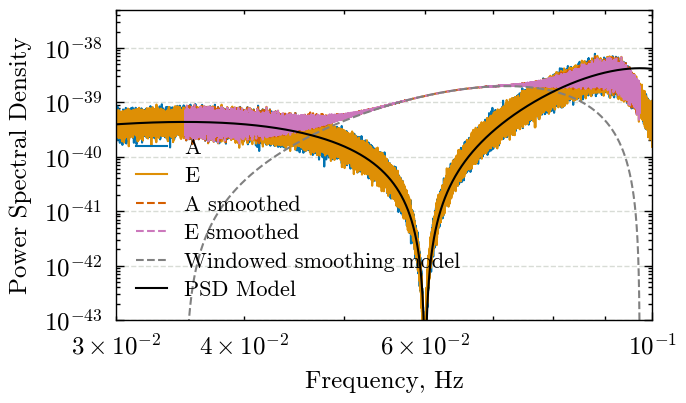

In [17]:
fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd, c=cycle[0], label='A')
ax.loglog(E_psd.sample_frequencies, E_psd, c=cycle[1], label='E')
ax.loglog(smoothed_freqs, fuzzy_line_A, label='A smoothed', linestyle='--', c=cycle[3])
ax.loglog(smoothed_freqs, fuzzy_line_E, label='E smoothed', linestyle='--', c=cycle[4])
# ax.loglog(smoothed_freqs, model_line, label='Smoothing model', linestyle='--', c='k')
ax.loglog(smoothed_freqs, model_line * windows.hann(model_line.size), label='Windowed smoothing model', linestyle='--', c='gray')



ax.loglog(ae_model.sample_frequencies, ae_model, c='k', label='PSD Model')
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
ax.legend(loc='lower left')
ax.set_ylim([1e-43, 5e-38])
ax.set_xlim([3e-2, 1e-1])
ax.grid(zorder=-100)


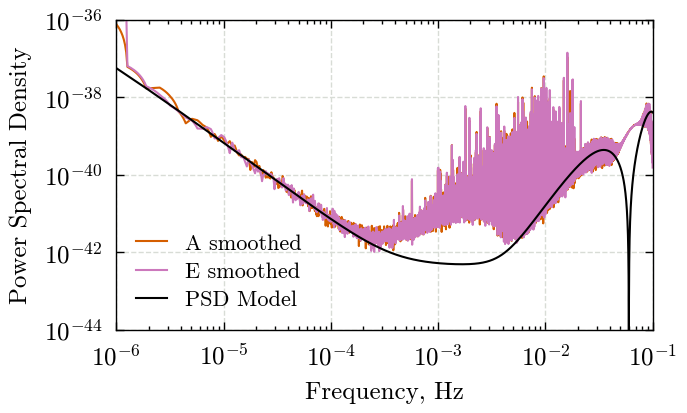

In [18]:
fig, ax = plt.subplots(1)
ax.loglog(A_psd.sample_frequencies, A_psd_smoothed, c=cycle[3], label='A smoothed')
ax.loglog(E_psd.sample_frequencies, E_psd_smoothed, c=cycle[4], label='E smoothed')
ax.loglog(ae_model.sample_frequencies, ae_model, c='k', label='PSD Model')
ax.set_ylabel("Power Spectral Density")
ax.set_xlabel("Frequency, Hz")
ax.legend(loc='lower left')
ax.set_ylim([1e-44, 1e-36])
ax.set_xlim([1e-6, 1e-1])
ax.grid(zorder=-100)